<a href="https://colab.research.google.com/github/OmerrYildirim/HuaweiProject/blob/main/Huawei_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import shutil
import os
import kagglehub

src_path = kagglehub.dataset_download("mohammedjaveed/loveda-dataset")
dst_path = "/content/loveda-dataset"

# Kopyala (veya taşı)
if not os.path.exists(dst_path):
    shutil.copytree(src_path, dst_path)

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class LoveDADataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_filenames = sorted(os.listdir(image_dir))  # ensure matching order
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)  # do not convert to RGB

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = mask.squeeze(0)
        mask = mask.long()

        mask[mask == 7] = 0


        return image, mask


In [ ]:
import torchvision.transforms as T

image_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

mask_transform = T.Compose([
    T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
    T.PILToTensor(),
])



| Tür                  | Açıklama                                           | Avantajları                                | Dezavantajları                                | Kullanım Alanları                 |
| -------------------- | -------------------------------------------------- | ------------------------------------------ | --------------------------------------------- | --------------------------------- |
| **Nearest Neighbor** | En yakın pikselin değerini aynen alır.             | Çok hızlı, sınıf maskeleri için ideal.     | Kenarlar keskin olabilir, görüntü pürüzlü.    | Segmentasyon maskeleri, etiketler |
| **Bilinear**         | Komşu 4 pikselin ağırlıklı ortalamasını alır.      | Daha yumuşak sonuçlar, doğal görünüm.      | Maskelerde sınıf karışıklığı olabilir.        | Fotoğraflar, genel görüntüler     |
| **Bicubic**          | Komşu 16 pikselin karmaşık ağırlıklı ortalaması.   | Daha yumuşak, keskin ve kaliteli sonuçlar. | Daha yavaş, maskelerde hataya neden olabilir. | Fotoğraf büyütme, baskı işleri    |
| **Lanczos**          | Matematiksel olarak daha karmaşık, yüksek kaliteli | Çok keskin, kaliteli sonuç.                | Hesaplama maliyeti yüksek.                    | Profesyonel görüntü işleme        |


In [ ]:
from torch.utils.data import DataLoader, random_split

# Artık sabit path'in var:
image_dir = "/content/loveda-dataset/Train/Train/Urban/images_png"
mask_dir  = "/content/loveda-dataset/Train/Train/Urban/masks_png"

train_dataset = LoveDADataset(image_dir, mask_dir,
                               transform=image_transform,
                               mask_transform=mask_transform)

val_ratio = 0.2
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False)




8 batch size
3 Kanal sayısı (RGB için 3)
H Height
W Weight


In [ ]:
images, masks = next(iter(train_loader))
print(images.shape)  # e.g., torch.Size([8, 3, H, W])
print(masks.shape)   # e.g., torch.Size([8, 1, H, W])


torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])


In [ ]:
class LoveDAClassNames:
    def __init__(self):
        self.classes = {
            0: "Background",
            1: "Building",
            2: "Road",
            3: "Water",
            4: "Barren",
            5: "Forest",
            6: "Agriculture",
        }

    def get_class_name(self, class_id):
        return self.classes.get(class_id, "Unknown")

    def print_all_classes(self):
        for class_id, class_name in self.classes.items():
            print(f"Class ID {class_id}: {class_name}")

# Kullanımı:
labels = LoveDAClassNames()
labels.print_all_classes()

print(labels.get_class_name(3))  # Output: Water


Class ID 0: Background
Class ID 1: Building
Class ID 2: Road
Class ID 3: Water
Class ID 4: Barren
Class ID 5: Forest
Class ID 6: Agriculture
Water


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from PIL import Image
import os


UNET


In [ ]:
# === UNET_MODEL_START ===

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        # Encoder
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        # Decoder
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return out
# === UNET_MODEL_END ===

UNET_END

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, jaccard_score
import numpy as np

def calculate_metrics(preds, targets, num_classes):
    preds = preds.cpu().numpy().flatten()
    targets = targets.cpu().numpy().flatten()

    # Precision, F1, Accuracy: macro average
    precision = precision_score(targets, preds, average='macro', zero_division=0)
    f1 = f1_score(targets, preds, average='macro', zero_division=0)
    acc = accuracy_score(targets, preds)
    iou = jaccard_score(targets, preds, average='macro', zero_division=0)

    return precision, f1, acc, iou


In [ ]:
##YENİ
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score

def calculate_metrics(preds, targets, num_classes):
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)

    precision = precision_score(targets_flat, preds_flat, average='macro', zero_division=0)
    recall = recall_score(targets_flat, preds_flat, average='macro', zero_division=0)
    f1 = f1_score(targets_flat, preds_flat, average='macro', zero_division=0)
    acc = accuracy_score(targets_flat, preds_flat)
    iou = jaccard_score(targets_flat, preds_flat, average='macro', zero_division=0)

    return precision, recall, f1, acc, iou


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_classes=7)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_classes = 7

patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # Validation aşaması
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)

            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_masks)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping ve best val loss kontrolü
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")  # En iyi modeli kaydet
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


Epoch [1/50], Train Loss: 1.5304, Val Loss: 1.3549
Epoch [2/50], Train Loss: 1.2953, Val Loss: 1.2968
Epoch [3/50], Train Loss: 1.1909, Val Loss: 1.1193
Epoch [4/50], Train Loss: 1.1264, Val Loss: 1.0537
Epoch [5/50], Train Loss: 1.0464, Val Loss: 1.0200
Epoch [6/50], Train Loss: 0.9969, Val Loss: 0.9449
Epoch [7/50], Train Loss: 0.9533, Val Loss: 0.9124
Epoch [8/50], Train Loss: 0.9169, Val Loss: 0.9748
Epoch [9/50], Train Loss: 0.8837, Val Loss: 0.8661
Epoch [10/50], Train Loss: 0.8743, Val Loss: 0.9437
Epoch [11/50], Train Loss: 0.8435, Val Loss: 0.8212
Epoch [12/50], Train Loss: 0.8191, Val Loss: 0.8211
Epoch [13/50], Train Loss: 0.8037, Val Loss: 0.8183
Epoch [14/50], Train Loss: 0.7809, Val Loss: 0.8033
Epoch [15/50], Train Loss: 0.7664, Val Loss: 0.7769
Epoch [16/50], Train Loss: 0.7628, Val Loss: 0.8013
Epoch [17/50], Train Loss: 0.7338, Val Loss: 0.7766
Epoch [18/50], Train Loss: 0.7241, Val Loss: 0.7682
Epoch [19/50], Train Loss: 0.7086, Val Loss: 0.8274
Epoch [20/50], Train 

In [ ]:
# Eğitim sonrası model performansını değerlendirme
model.eval()
all_preds = []
all_targets = []
num_classes = 7

with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)  # [B, C, H, W]
        preds = torch.argmax(outputs, dim=1)  # [B, H, W]

        all_preds.append(preds.cpu())
        all_targets.append(masks.cpu())

# Tüm batch'leri birleştir
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Metrikleri hesapla
precision, recall, f1, acc, iou = calculate_metrics(all_preds, all_targets, num_classes)

print("\n=== Eğitim Sonu Genel Metrikler ===")
print(f"Accuracy :  {acc:.4f}")
print(f"F1 Score :  {f1:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall   :  {recall:.4f}")
print(f"IoU      :  {iou:.4f}")



=== Eğitim Sonu Genel Metrikler ===
Accuracy :  0.8146
F1 Score :  0.8123
Precision:  0.8345
Recall   :  0.8092
IoU      :  0.6951


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_prediction(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(dataloader))
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)  # [B, n_classes, H, W]
        preds = torch.argmax(outputs, dim=1)  # [B, H, W]

        # İlk örneği alalım
        img = images[2].cpu()
        mask = masks[2].cpu()
        pred = preds[2].cpu()

        # Görüntüyü normalize edilmiş halinden orijinale döndür (denormalize)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        img = img * std + mean
        img = img.clamp(0,1)

        # Maskeleri numpy array’e çevir
        mask = mask.numpy()
        pred = pred.numpy()

        # Renk paleti ve etiketler
        COLOR_MAP = {
          0: (255, 255, 255),   # Background
          1: (255, 0, 0),       # Building
          2: (255, 255, 0),     # Road
          3: (0, 0, 255),       # Water
          4: (159, 129, 183),   # Barren
          5: (0, 255, 0),       # Forest
          6: (255, 195, 128),   # Agricultural
          255: (0, 0, 0),       # IGNORE — siyah
        }



        labels = {
            0: "Background",
            1: "Building",
            2: "Road",
            3: "Water",
            4: "Barren",
            5: "Forest",
            6: "Agriculture",
            255: "IGNORE"
        }

        # Renkli maske oluşturucu
        def label_to_color(mask):
            h, w = mask.shape
            color_mask = np.zeros((h, w, 3), dtype=np.uint8)
            for class_id, color in COLOR_MAP.items():
               color_mask[mask == class_id] = color
            return color_mask

        color_mask = label_to_color(mask)
        color_pred = label_to_color(pred)

        # Görselleri göster
                # Görselleri göster
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(img.permute(1,2,0))
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(color_mask)
        axs[1].set_title("Ground Truth Mask")
        axs[1].axis('off')

        axs[2].imshow(color_pred)
        axs[2].set_title("Predicted Mask")
        axs[2].axis('off')

        # --- RENKLİ LEGEND BURADA EKLENİYOR ---
        from matplotlib.patches import Patch

        legend_elements = [
            Patch(facecolor=np.array(COLOR_MAP[class_id]) / 255.0, label=label)
            for class_id, label in labels.items()
        ]


        axs[2].legend(handles=legend_elements,
                      loc='lower right',
                      bbox_to_anchor=(1.5, 0),
                      title="Classes",
                      fontsize=10,
                      title_fontsize=12,
                      frameon=True)

        plt.tight_layout()
        plt.show()


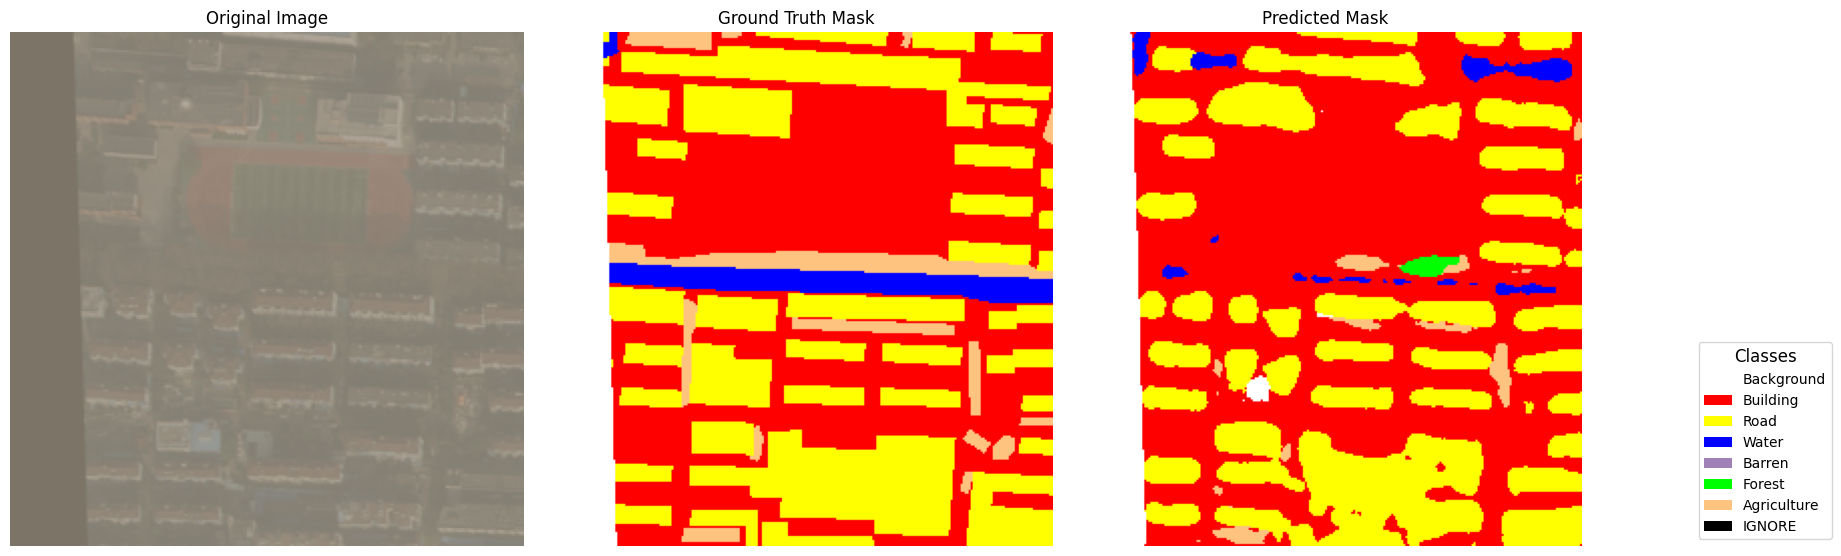

In [ ]:
visualize_prediction(model, train_loader, device)


FCN

In [ ]:
import torchvision.models.segmentation as models


In [ ]:
from torchvision.models.segmentation import fcn_resnet50

# Modeli yükle, pretrained=False (ImageNet değil)
fcn_model = fcn_resnet50(pretrained=False, num_classes=7)  # 7 sınıf
fcn_model = fcn_model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fcn_model.parameters(), lr=1e-4)


In [ ]:
num_epochs = 50
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

model=fcn_model

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # Validation aşaması
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)

            val_outputs = model(val_images)['out']
            loss = criterion(val_outputs, val_masks)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping kontrolü
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Modeli kaydetmek istersen burada yapabilirsin
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


Epoch [1/50], Train Loss: 1.1237, Val Loss: 0.8983
Epoch [2/50], Train Loss: 0.8231, Val Loss: 0.7926
Epoch [3/50], Train Loss: 0.7074, Val Loss: 0.7638
Epoch [4/50], Train Loss: 0.6087, Val Loss: 0.8114
Epoch [5/50], Train Loss: 0.5400, Val Loss: 0.7516
Epoch [6/50], Train Loss: 0.4901, Val Loss: 0.7297
Epoch [7/50], Train Loss: 0.4505, Val Loss: 0.7197
Epoch [8/50], Train Loss: 0.4120, Val Loss: 0.7220
Epoch [9/50], Train Loss: 0.3790, Val Loss: 0.7347
Epoch [10/50], Train Loss: 0.3533, Val Loss: 0.7440
Epoch [11/50], Train Loss: 0.3233, Val Loss: 0.7442
Epoch [12/50], Train Loss: 0.3034, Val Loss: 0.7300
Early stopping triggered after 12 epochs.


In [ ]:
# Eğitim sonrası model performansını değerlendirme
model.eval()
all_preds = []
all_targets = []
num_classes = 7

with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)["out"]  # [B, C, H, W]
        preds = torch.argmax(outputs, dim=1)  # [B, H, W]

        all_preds.append(preds.cpu())
        all_targets.append(masks.cpu())

# Tüm batch'leri birleştir
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Metrikleri hesapla
precision, recall, f1, acc, iou = calculate_metrics(all_preds, all_targets, num_classes)

print("\n=== Eğitim Sonu Genel Metrikler ===")
print(f"Accuracy :  {acc:.4f}")
print(f"F1 Score :  {f1:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall   :  {recall:.4f}")
print(f"IoU      :  {iou:.4f}")



=== Eğitim Sonu Genel Metrikler ===
Accuracy :  0.8948
F1 Score :  0.9049
Precision:  0.9046
Recall   :  0.9052
IoU      :  0.8292


In [ ]:
def visualize_prediction(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(dataloader))
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)['out']  # FCN için yine ['out']
        preds = torch.argmax(outputs, dim=1)

         # İlk örneği alalım
        img = images[2].cpu()
        mask = masks[2].cpu()
        pred = preds[2].cpu()

        # Görüntüyü normalize edilmiş halinden orijinale döndür (denormalize)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        img = img * std + mean
        img = img.clamp(0,1)

        # Maskeleri numpy array’e çevir
        mask = mask.numpy()
        pred = pred.numpy()

        # Renk paleti ve etiketler
        palette = {
            0: [255, 255, 255],     # Background - beyaz
            1: [128, 0, 0],         # Building - koyu kırmızı    Background
            2: [255, 255, 0],       # Road - sarı                Building olucak
            3: [0, 0, 128],         # Water - koyu mavi          Yol
            4: [128, 64, 128],      # Barren - morumsu
            5: [0, 128, 0],         # Forest - yeşil
            6: [189, 183, 107]      # Agriculture - bozkır rengi
        }

        labels = {
            0: "Background",
            1: "Building",
            2: "Road",
            3: "Water",
            4: "Barren",
            5: "Forest",
            6: "Agriculture"
        }

        # Renkli maske oluşturucu
        def label_to_color(mask):
            h, w = mask.shape
            color_mask = np.zeros((h, w, 3), dtype=np.uint8)
            for k, v in palette.items():
                color_mask[mask == k] = v
            return color_mask

        color_mask = label_to_color(mask)
        color_pred = label_to_color(pred)

        # Görselleri göster
                # Görselleri göster
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(img.permute(1,2,0))
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(color_mask)
        axs[1].set_title("Ground Truth Mask")
        axs[1].axis('off')

        axs[2].imshow(color_pred)
        axs[2].set_title("Predicted Mask")
        axs[2].axis('off')

        # --- RENKLİ LEGEND BURADA EKLENİYOR ---
        from matplotlib.patches import Patch

        legend_elements = [
            Patch(facecolor=np.array(color)/255.0, label=label)
            for label, color in zip(labels.values(), palette.values())
        ]

        axs[2].legend(handles=legend_elements,
                      loc='lower right',
                      bbox_to_anchor=(1.5, 0),
                      title="Classes",
                      fontsize=10,
                      title_fontsize=12,
                      frameon=True)

        plt.tight_layout()
        plt.show()



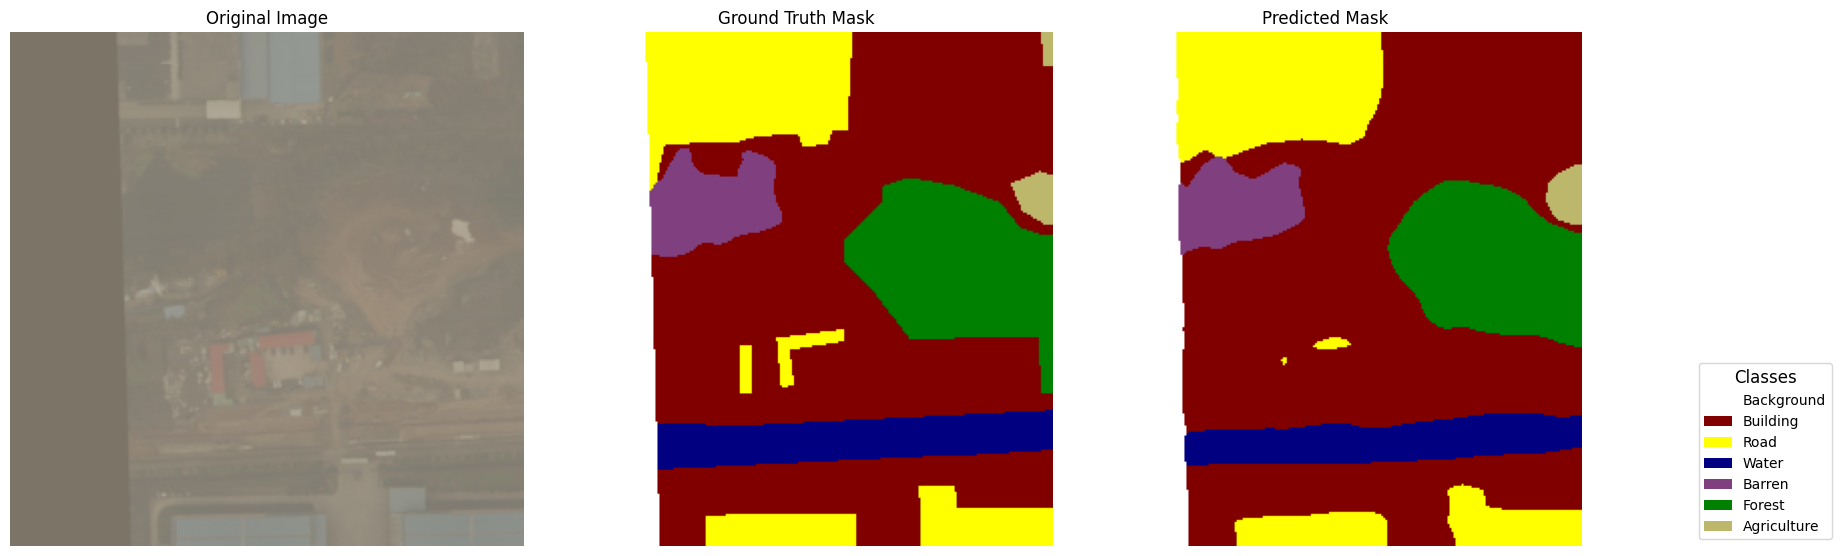

In [ ]:
visualize_prediction(model, train_loader, device)


deeplab


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models.segmentation import deeplabv3_resnet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modeli oluştur
model = deeplabv3_resnet50(pretrained=False, num_classes=7)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)
            val_outputs = model(val_images)['out']
            val_loss = criterion(val_outputs, val_masks)
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early stopping kontrolü
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_deeplab_model.pth")  # En iyi modeli kaydet
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Train Loss: 1.2672, Val Loss: 1.0031
Epoch [2/50], Train Loss: 0.8954, Val Loss: 0.8908
Epoch [3/50], Train Loss: 0.7442, Val Loss: 0.8125
Epoch [4/50], Train Loss: 0.6784, Val Loss: 0.7811
Epoch [5/50], Train Loss: 0.5983, Val Loss: 0.7367
Epoch [6/50], Train Loss: 0.5290, Val Loss: 0.7680
Epoch [7/50], Train Loss: 0.4865, Val Loss: 0.7195
Epoch [8/50], Train Loss: 0.4523, Val Loss: 0.7228
Epoch [9/50], Train Loss: 0.4212, Val Loss: 0.6982
Epoch [10/50], Train Loss: 0.3904, Val Loss: 0.7272
Epoch [11/50], Train Loss: 0.3631, Val Loss: 0.7130
Epoch [12/50], Train Loss: 0.3358, Val Loss: 0.7317
Epoch [13/50], Train Loss: 0.3244, Val Loss: 0.7561
Epoch [14/50], Train Loss: 0.3017, Val Loss: 0.7493
Early stopping triggered


In [ ]:
# Eğitim sonrası model performansını değerlendirme
model.eval()
all_preds = []
all_targets = []
num_classes = 7

with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)["out"]  # [B, C, H, W]
        preds = torch.argmax(outputs, dim=1)  # [B, H, W]

        all_preds.append(preds.cpu())
        all_targets.append(masks.cpu())

# Tüm batch'leri birleştir
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Metrikleri hesapla
precision, recall, f1, acc, iou = calculate_metrics(all_preds, all_targets, num_classes)

print("\n=== Eğitim Sonu Genel Metrikler ===")
print(f"Accuracy :  {acc:.4f}")
print(f"F1 Score :  {f1:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall   :  {recall:.4f}")
print(f"IoU      :  {iou:.4f}")



=== Eğitim Sonu Genel Metrikler ===
Accuracy :  0.8939
F1 Score :  0.9020
Precision:  0.8938
Recall   :  0.9113
IoU      :  0.8240


In [ ]:
def visualize_prediction(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(dataloader))
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)['out']  # FPN için yine ['out']
        preds = torch.argmax(outputs, dim=1)

         # İlk örneği alalım
        img = images[2].cpu()
        mask = masks[2].cpu()
        pred = preds[2].cpu()

        # Görüntüyü normalize edilmiş halinden orijinale döndür (denormalize)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        img = img * std + mean
        img = img.clamp(0,1)

        # Maskeleri numpy array’e çevir
        mask = mask.numpy()
        pred = pred.numpy()

        # Renk paleti ve etiketler
        palette = {
            0: [255, 255, 255],     # Background - beyaz
            1: [128, 0, 0],         # Building - koyu kırmızı    Background
            2: [255, 255, 0],       # Road - sarı                Building olucak
            3: [0, 0, 128],         # Water - koyu mavi          Yol
            4: [128, 64, 128],      # Barren - morumsu
            5: [0, 128, 0],         # Forest - yeşil
            6: [189, 183, 107]      # Agriculture - bozkır rengi
        }

        labels = {
            0: "Background",
            1: "Building",
            2: "Road",
            3: "Water",
            4: "Barren",
            5: "Forest",
            6: "Agriculture"
        }

        # Renkli maske oluşturucu
        def label_to_color(mask):
            h, w = mask.shape
            color_mask = np.zeros((h, w, 3), dtype=np.uint8)
            for k, v in palette.items():
                color_mask[mask == k] = v
            return color_mask

        color_mask = label_to_color(mask)
        color_pred = label_to_color(pred)

        # Görselleri göster
                # Görselleri göster
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(img.permute(1,2,0))
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(color_mask)
        axs[1].set_title("Ground Truth Mask")
        axs[1].axis('off')

        axs[2].imshow(color_pred)
        axs[2].set_title("Predicted Mask")
        axs[2].axis('off')

        # --- RENKLİ LEGEND BURADA EKLENİYOR ---
        from matplotlib.patches import Patch

        legend_elements = [
            Patch(facecolor=np.array(color)/255.0, label=label)
            for label, color in zip(labels.values(), palette.values())
        ]

        axs[2].legend(handles=legend_elements,
                      loc='lower right',
                      bbox_to_anchor=(1.5, 0),
                      title="Classes",
                      fontsize=10,
                      title_fontsize=12,
                      frameon=True)

        plt.tight_layout()
        plt.show()



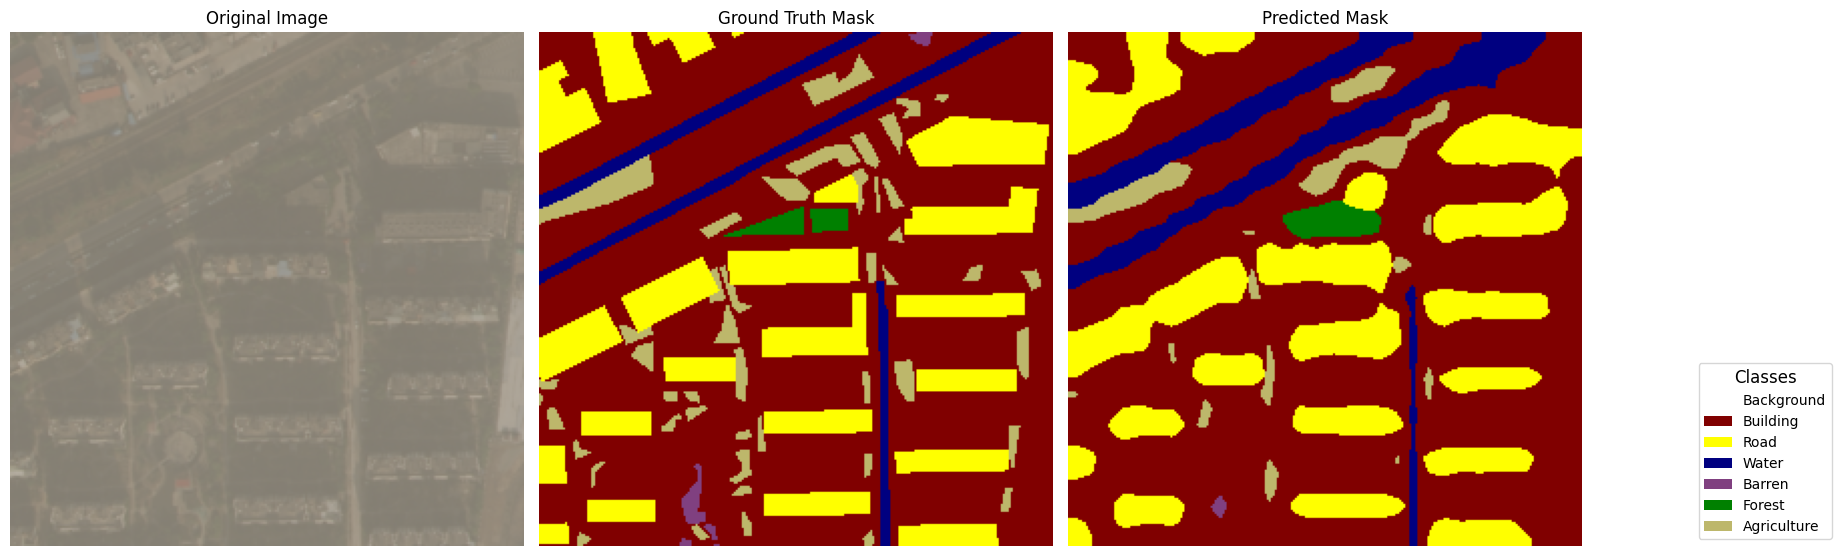

In [ ]:
visualize_prediction(model, train_loader, device)


In [ ]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [ ]:
import segmentation_models_pytorch as smp





PSPNet


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# PSPNet modelini uygun şekilde içe aktar
# Örneğin:
# from your_model_file import PSPNet  # kendi model tanımına göre düzenle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# PSPNet modelini oluştur

model = smp.PSPNet(
    encoder_name="resnet34",      # backbone (dilersen resnet50, efficientnet, vb.)
    encoder_weights="imagenet",   # önceden eğitilmiş ağırlıklar
    in_channels=3,                # Giriş kanal sayısı (RGB için 3)
    classes=7                     # Çıkış sınıf sayısı
)  # num_classes çıktıya göre ayarlanmalı
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Eğer output shape [B, C, H, W] ve mask shape [B, H, W] ise bu doğrudur
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # Validation aşaması
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)

            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_masks)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping ve best val loss kontrolü
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_pspnet_model.pth")  # En iyi modeli kaydet
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Epoch [1/50], Train Loss: 1.2703, Val Loss: 1.0206
Epoch [2/50], Train Loss: 1.0069, Val Loss: 0.9891
Epoch [3/50], Train Loss: 0.9181, Val Loss: 0.9193
Epoch [4/50], Train Loss: 0.8589, Val Loss: 0.8645
Epoch [5/50], Train Loss: 0.8213, Val Loss: 0.8087
Epoch [6/50], Train Loss: 0.7894, Val Loss: 0.8133
Epoch [7/50], Train Loss: 0.7575, Val Loss: 0.7952
Epoch [8/50], Train Loss: 0.7292, Val Loss: 0.7875
Epoch [9/50], Train Loss: 0.7068, Val Loss: 0.7817
Epoch [10/50], Train Loss: 0.6818, Val Loss: 0.7726
Epoch [11/50], Train Loss: 0.6547, Val Loss: 0.8044
Epoch [12/50], Train Loss: 0.6457, Val Loss: 0.7952
Epoch [13/50], Train Loss: 0.6304, Val Loss: 0.7563
Epoch [14/50], Train Loss: 0.6141, Val Loss: 0.7792
Epoch [15/50], Train Loss: 0.5905, Val Loss: 0.7579
Epoch [16/50], Train Loss: 0.5740, Val Loss: 0.7627
Epoch [17/50], Train Loss: 0.5672, Val Loss: 0.7540
Epoch [18/50], Train Loss: 0.5535, Val Loss: 0.7787
Epoch [19/50], Train Loss: 0.5433, Val Loss: 0.7645
Epoch [20/50], Train 

In [ ]:
# Eğitim sonrası model performansını değerlendirme
model.eval()
all_preds = []
all_targets = []
num_classes = 7

with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)  # [B, C, H, W]
        preds = torch.argmax(outputs, dim=1)  # [B, H, W]

        all_preds.append(preds.cpu())
        all_targets.append(masks.cpu())

# Tüm batch'leri birleştir
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Metrikleri hesapla
precision, recall, f1, acc, iou = calculate_metrics(all_preds, all_targets, num_classes)

print("\n=== Eğitim Sonu Genel Metrikler ===")
print(f"Accuracy :  {acc:.4f}")
print(f"F1 Score :  {f1:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall   :  {recall:.4f}")
print(f"IoU      :  {iou:.4f}")



=== Eğitim Sonu Genel Metrikler ===
Accuracy :  0.8214
F1 Score :  0.8398
Precision:  0.8410
Recall   :  0.8416
IoU      :  0.7302


In [ ]:
def visualize_prediction(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(dataloader))
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

         # İlk örneği alalım
        img = images[2].cpu()
        mask = masks[2].cpu()
        pred = preds[2].cpu()

        # Görüntüyü normalize edilmiş halinden orijinale döndür (denormalize)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        img = img * std + mean
        img = img.clamp(0,1)

        # Maskeleri numpy array’e çevir
        mask = mask.numpy()
        pred = pred.numpy()

        # Renk paleti ve etiketler
        palette = {
            0: [255, 255, 255],     # Background - beyaz
            1: [128, 0, 0],         # Building - koyu kırmızı    Background
            2: [255, 255, 0],       # Road - sarı                Building olucak
            3: [0, 0, 128],         # Water - koyu mavi          Yol
            4: [128, 64, 128],      # Barren - morumsu
            5: [0, 128, 0],         # Forest - yeşil
            6: [189, 183, 107]      # Agriculture - bozkır rengi
        }

        labels = {
            0: "Background",
            1: "Building",
            2: "Road",
            3: "Water",
            4: "Barren",
            5: "Forest",
            6: "Agriculture"
        }

        # Renkli maske oluşturucu
        def label_to_color(mask):
            h, w = mask.shape
            color_mask = np.zeros((h, w, 3), dtype=np.uint8)
            for k, v in palette.items():
                color_mask[mask == k] = v
            return color_mask

        color_mask = label_to_color(mask)
        color_pred = label_to_color(pred)

        # Görselleri göster
                # Görselleri göster
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(img.permute(1,2,0))
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(color_mask)
        axs[1].set_title("Ground Truth Mask")
        axs[1].axis('off')

        axs[2].imshow(color_pred)
        axs[2].set_title("Predicted Mask")
        axs[2].axis('off')

        # --- RENKLİ LEGEND BURADA EKLENİYOR ---
        from matplotlib.patches import Patch

        legend_elements = [
            Patch(facecolor=np.array(color)/255.0, label=label)
            for label, color in zip(labels.values(), palette.values())
        ]

        axs[2].legend(handles=legend_elements,
                      loc='lower right',
                      bbox_to_anchor=(1.5, 0),
                      title="Classes",
                      fontsize=10,
                      title_fontsize=12,
                      frameon=True)

        plt.tight_layout()
        plt.show()



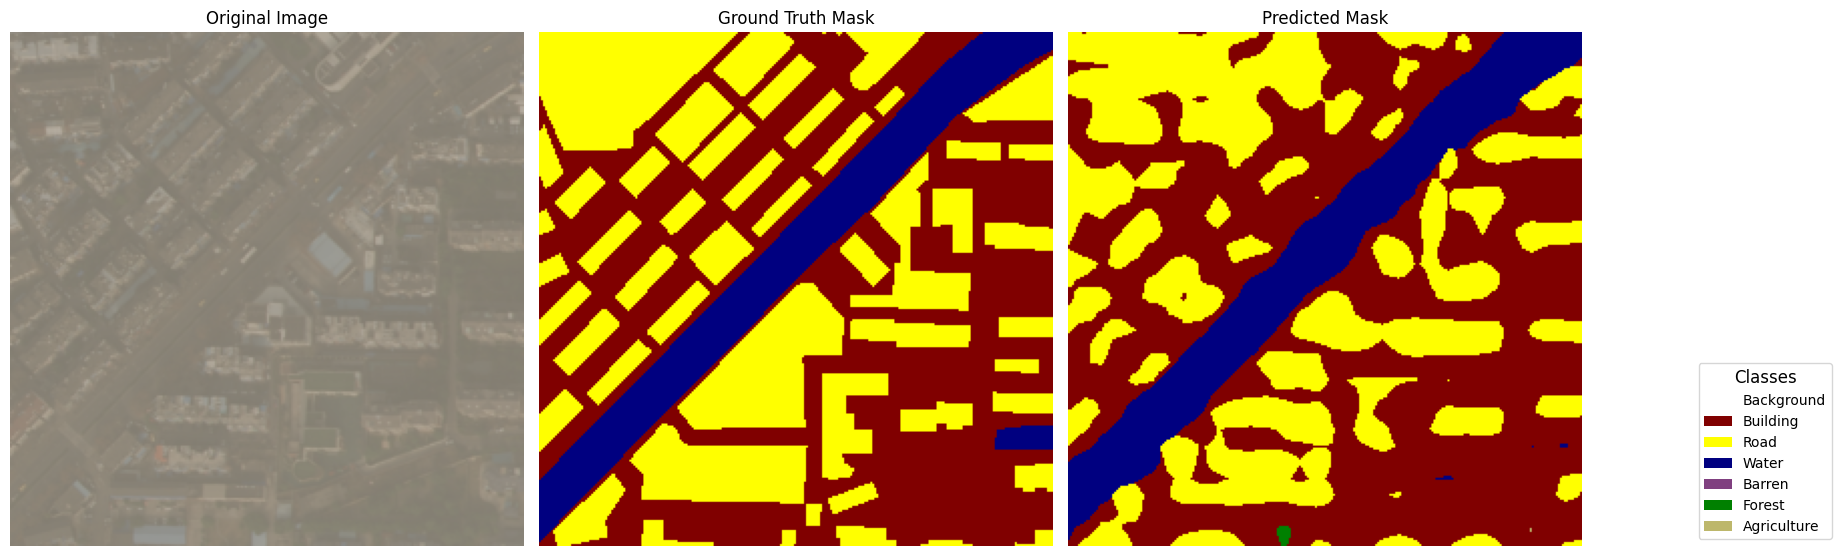

In [ ]:
visualize_prediction(model, train_loader, device)

In [ ]:
;